<a href="https://colab.research.google.com/github/ehsankarami1358/LOKA_HYDRO/blob/main/H%C4%B0LLCHART_VS_ACTUAL_LOKA_U2_2026_r2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
import os


In [60]:
# ---------------------------
# INPUT FILES (your uploads)
# ---------------------------
hill_path = r"/content/LOKA_Digital_hillchart_extracted.xlsx"
op_path   = r"/content/u2_MW_OP_FL_L_28_1_2026_26_2_2026_R2.csv"
out_dir   = r"/content/data"

# Create the output directory if it doesn't exist
os.makedirs(out_dir, exist_ok=True)

In [61]:
# ---------------------------
# 1) LOAD + PARSE HILL CHART
# ---------------------------
hill_raw = pd.read_excel(hill_path, sheet_name="Sheet1")

def parse_hill_blocks(df):
    blocks = []
    i = 0
    while i < len(df):
        v = df.iloc[i, 0]
        if isinstance(v, str) and v.strip().startswith("NetHead_m="):
            head = float(v.split("=")[1])

            # find next row with "ActivePower_MW"
            j = i + 1
            while j < min(i + 8, len(df)) and not (
                isinstance(df.iloc[j, 0], str) and df.iloc[j, 0].strip() == "ActivePower_MW"
            ):
                j += 1
            if j >= len(df):
                i += 1
                continue

            power = pd.to_numeric(df.iloc[j,   1:], errors="coerce").values
            flow  = pd.to_numeric(df.iloc[j+1, 1:], errors="coerce").values
            eta   = pd.to_numeric(df.iloc[j+2, 1:], errors="coerce").values
            opn   = pd.to_numeric(df.iloc[j+3, 1:], errors="coerce").values

            block = pd.DataFrame({
                "Head_m": head,
                "Power_MW": power,
                "Flow_m3s": flow,
                "Eta_hill": eta,
                "Opening_hill_pct": opn
            }).dropna(subset=["Power_MW", "Flow_m3s", "Eta_hill"])

            blocks.append(block)
            i = j + 4
        else:
            i += 1

    if blocks:
        return pd.concat(blocks, ignore_index=True)
    return pd.DataFrame(columns=["Head_m","Power_MW","Flow_m3s","Eta_hill","Opening_hill_pct"])

hill_table = parse_hill_blocks(hill_raw)

In [62]:
hill_table

,Head_m,Power_MW,Flow_m3s,Eta_hill,Opening_hill_pct
0,77.5,80.0,115.0,0.905,NaN
1,77.5,90.0,126.0,0.925,NaN
2,77.5,95.0,132.0,0.935,NaN
3,77.5,100.0,144.0,0.941,NaN
4,77.5,105.0,150.0,0.947,NaN
5,77.5,110.0,155.0,0.952,NaN
6,77.5,115.0,160.0,0.961,NaN
7,77.5,120.0,168.0,0.957,NaN
8,77.5,130.0,180.0,0.950,NaN
9,77.5,140.0,198.0,0.920,NaN


In [63]:
# Interpolators: Flow(H,P) and Eta(H,P)
X = hill_table[["Head_m","Power_MW"]].values
flow_interp = LinearNDInterpolator(X, hill_table["Flow_m3s"].values)
eta_interp  = LinearNDInterpolator(X, hill_table["Eta_hill"].values)
display(flow_interp)

In [64]:
# ---------------------------
# 2) LOAD OPERATING CSV
# ---------------------------
op = pd.read_csv(op_path)
op["Timestamp"] = pd.to_datetime(op["Timestamp"], errors="coerce")

op["NetHead_m"] = op["HEAD_L(m)"] - op["TAIL_L(m)"]
op["Power_MW"]  = op["ACTIVE_POWER(MW)"]
op["Flow_m3s"]  = op["FLOW(m3/s)"]
op["Opening_pct"] = op["OPPENING(%)"]
op["Speed_rpm"] = op["SPEED(RPM)"]

op = op.dropna(subset=["Timestamp","NetHead_m","Power_MW","Flow_m3s","Speed_rpm"])

# Nominal speed from running points
run_mask = (op["Power_MW"] > 20) & (op["Flow_m3s"] > 5)
nom_speed = op.loc[run_mask, "Speed_rpm"].median()

# Stable filter (tune if needed)
stable_mask = (
    (op["Power_MW"] > 20) &
    (op["Flow_m3s"] > 5) &
    (op["Opening_pct"] > 1) &
    (op["Speed_rpm"].between(nom_speed - 0.5, nom_speed + 0.5))
)
op_stable = op.loc[stable_mask].copy()

In [65]:

# ---------------------------
# 3) ACTUAL EFFICIENCY
# ---------------------------
rho = 1000.0
g = 9.80665
op_stable["NetHead_m"]=op_stable["NetHead_m"]
electrical_efficiency = 0.98 # As per user request
op_stable["Eta_actual"] = (op_stable["Power_MW"]*1e6) / (rho*g*op_stable["Flow_m3s"]*op_stable["NetHead_m"])
op_stable["Eta_actual"] = op_stable["Eta_actual"] / electrical_efficiency # Convert overall to mechanical efficiency

# ---------------------------
# 4) EXPECTED FROM HILL CHART
# ---------------------------
op_stable["Flow_expected"] = flow_interp(op_stable["NetHead_m"].values, op_stable["Power_MW"].values)
op_stable["Eta_expected"]  = eta_interp(op_stable["NetHead_m"].values, op_stable["Power_MW"].values)

# Keep only points inside hill chart domain
op_cmp = op_stable.dropna(subset=["Flow_expected","Eta_expected"]).copy()

op_cmp["Flow_error_m3s"] = op_cmp["Flow_m3s"] - op_cmp["Flow_expected"]
op_cmp["Flow_error_pct"] = 100.0 * op_cmp["Flow_error_m3s"] / op_cmp["Flow_expected"]

op_cmp["Eta_error"]      = op_cmp["Eta_actual"] - op_cmp["Eta_expected"]
op_cmp["Eta_error_pct"]  = 100.0 * op_cmp["Eta_error"] / op_cmp["Eta_expected"]

# ---------------------------
# 5) QUICK SUMMARY
# ---------------------------
print("Stable points:", len(op_cmp))
print("Net head range (m):", op_cmp["NetHead_m"].min(), "to", op_cmp["NetHead_m"].max())
print("Power range (MW):", op_cmp["Power_MW"].min(), "to", op_cmp["Power_MW"].max())
print("Net head mean (m):",op_cmp["NetHead_m"].mean())
print("Power range (MW):",op_cmp["Power_MW"].mean())

Stable points: 896
Net head range (m): 78.71204 to 86.89003999999989
Power range (MW): 81.46896 to 141.5192
Net head mean (m): 82.34949870535714
Power range (MW): 109.65077011160713


In [66]:
print(op_stable[["NetHead_m","Power_MW","Flow_expected","Eta_expected"]])

     NetHead_m  Power_MW  Flow_expected  Eta_expected
20    82.76304  117.9393      152.00108      0.961703
21    82.88404  108.9977      143.22962      0.945597
22    82.82304  111.3907      145.46648      0.949781
23    82.91104  105.3012      139.47912      0.940422
24    82.77304  117.2180      151.11552      0.960549
..         ...       ...            ...           ...
934   78.91704  109.3147      151.48062      0.951315
935   78.76604  117.3872      159.85512      0.961477
936   78.83104  113.1682      155.50612      0.957703
937   78.96204  104.8852      146.91520      0.946862
938   78.95604  104.8862      146.92860      0.946863

[896 rows x 4 columns]


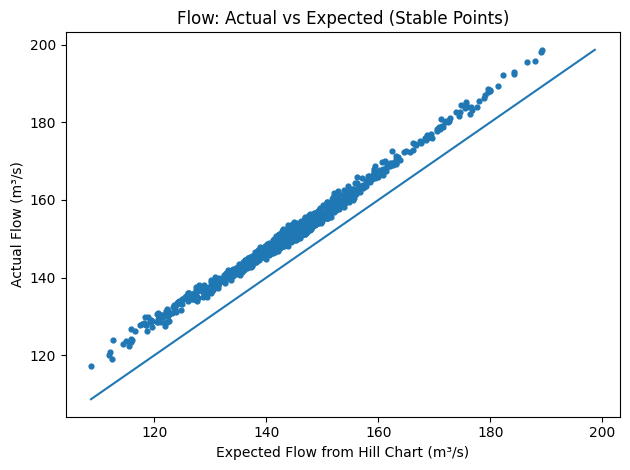

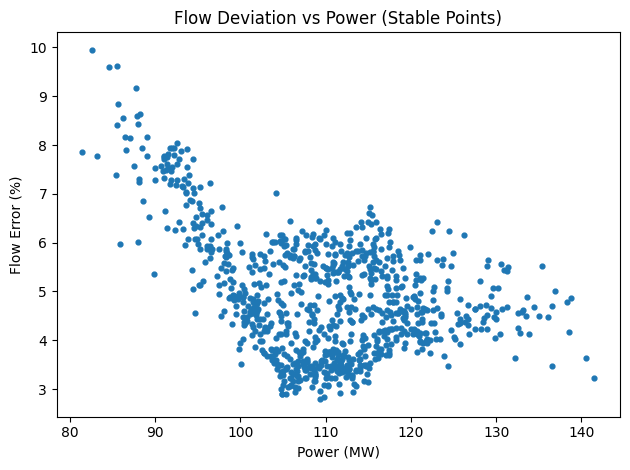

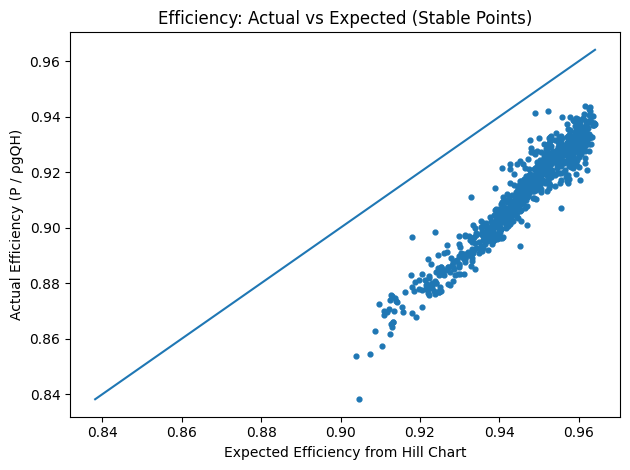

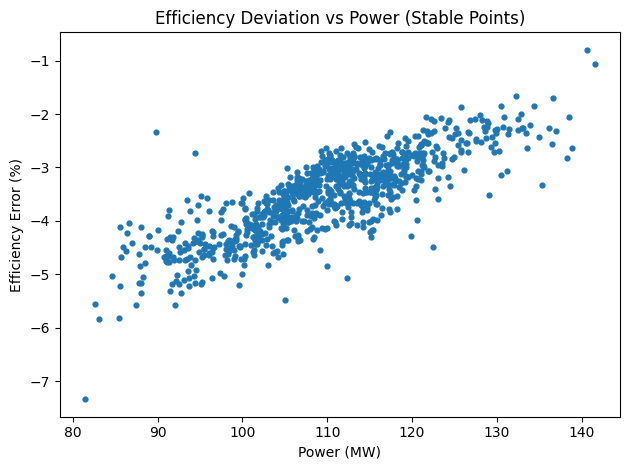

In [67]:
# ---------------------------
# 6) PLOTS (no seaborn)
# ---------------------------
# Actual vs Expected Flow
plt.figure()
plt.scatter(op_cmp["Flow_expected"], op_cmp["Flow_m3s"], s=12)
mn = min(op_cmp["Flow_expected"].min(), op_cmp["Flow_m3s"].min())
mx = max(op_cmp["Flow_expected"].max(), op_cmp["Flow_m3s"].max())
plt.plot([mn,mx],[mn,mx])
plt.xlabel("Expected Flow from Hill Chart (m³/s)")
plt.ylabel("Actual Flow (m³/s)")
plt.title("Flow: Actual vs Expected (Stable Points)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "flow_actual_vs_expected.png"), dpi=200)
plt.show()

# Flow error vs Power
plt.figure()
plt.scatter(op_cmp["Power_MW"], op_cmp["Flow_error_pct"], s=12)
plt.xlabel("Power (MW)")
plt.ylabel("Flow Error (%)")
plt.title("Flow Deviation vs Power (Stable Points)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "flow_error_pct_vs_power.png"), dpi=200)
plt.show()

# Efficiency actual vs expected
plt.figure()
plt.scatter(op_cmp["Eta_expected"], op_cmp["Eta_actual"], s=12)
mn = min(op_cmp["Eta_expected"].min(), op_cmp["Eta_actual"].min())
mx = max(op_cmp["Eta_expected"].max(), op_cmp["Eta_actual"].max())
plt.plot([mn,mx],[mn,mx])
plt.xlabel("Expected Efficiency from Hill Chart")
plt.ylabel("Actual Efficiency (P / ρgQH)")
plt.title("Efficiency: Actual vs Expected (Stable Points)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "eta_actual_vs_expected.png"), dpi=200)
plt.show()

# Efficiency error vs Power
plt.figure()
plt.scatter(op_cmp["Power_MW"], op_cmp["Eta_error_pct"], s=12)
plt.xlabel("Power (MW)")
plt.ylabel("Efficiency Error (%)")
plt.title("Efficiency Deviation vs Power (Stable Points)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "eta_error_pct_vs_power.png"), dpi=200)
plt.show()

# ---------------------------

In [68]:
# 7) EXPORT REPORT TO EXCEL
# ---------------------------
summary = pd.DataFrame([
    {
        "n_stable_points": len(op_cmp),
        "net_head_min_m": float(op_cmp["NetHead_m"].min()),
        "net_head_max_m": float(op_cmp["NetHead_m"].max()),
        "power_min_MW": float(op_cmp["Power_MW"].min()),
        "power_max_MW": float(op_cmp["Power_MW"].max()),
        "flow_error_mean_pct": float(op_cmp["Flow_error_pct"].mean()),
        "flow_error_median_pct": float(op_cmp["Flow_error_pct"].median()),
        "eta_error_mean_pct": float(op_cmp["Eta_error_pct"].mean()),
        "eta_error_median_pct": float(op_cmp["Eta_error_pct"].median()),
    }
])

report_path = os.path.join(out_dir, "unit2_vs_hillchart_report.xlsx")
with pd.ExcelWriter(report_path, engine="openpyxl") as w:
    summary.to_excel(w, index=False, sheet_name="Summary")
    hill_table.to_excel(w, index=False, sheet_name="Hill_flat_table")
    op_cmp.to_excel(w, index=False, sheet_name="Stable_points_with_compare")

print("Saved:", report_path)

Saved: /content/data/unit2_vs_hillchart_report.xlsx


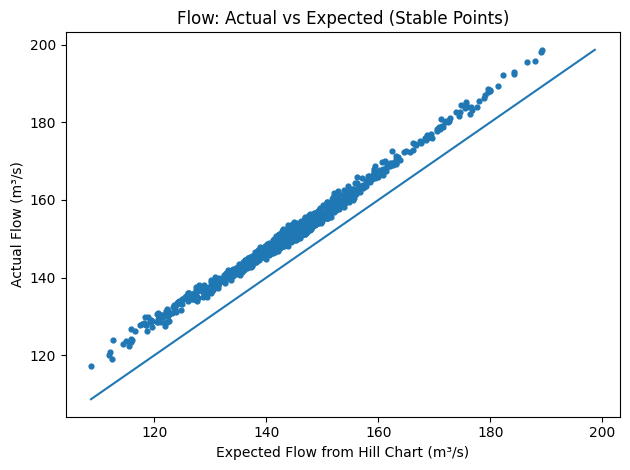

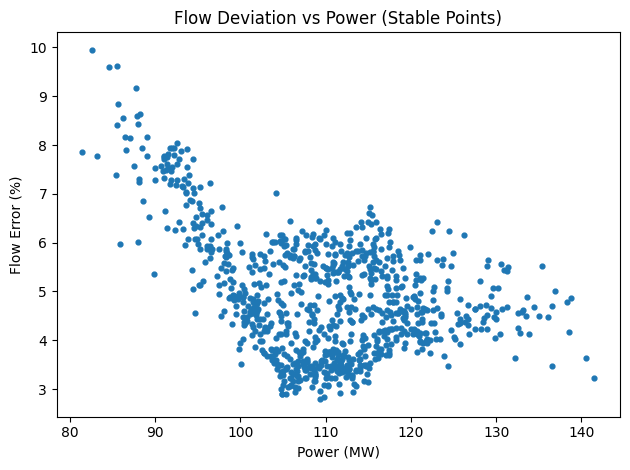

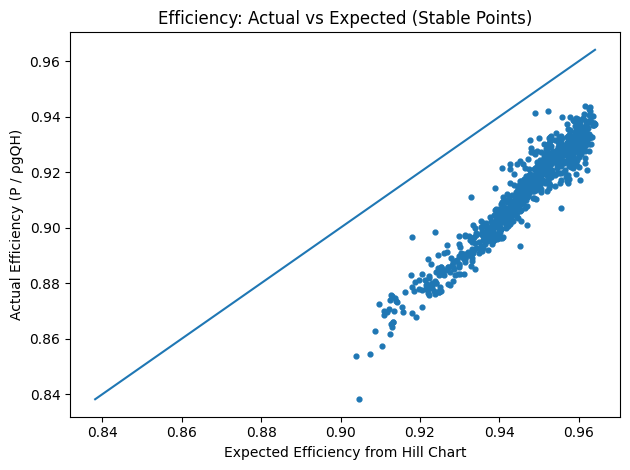

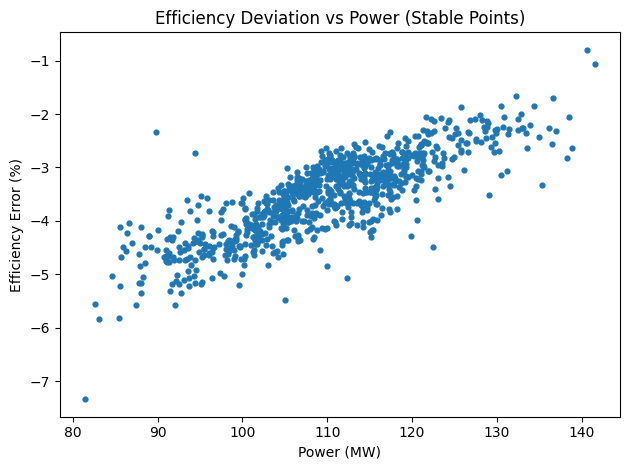

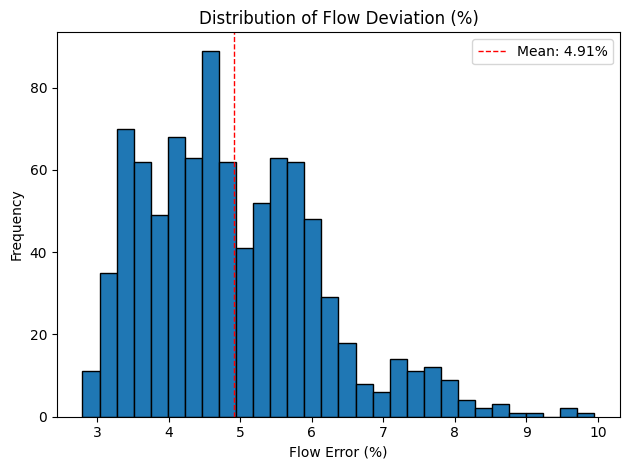

Mean Flow Error: 4.91%


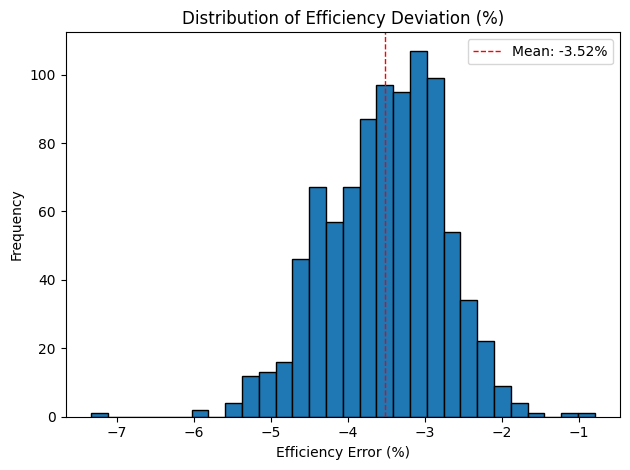

Mean Efficiency Error: -3.52%


In [69]:
# ---------------------------
# 6) PLOTS (no seaborn)
# ---------------------------
# Actual vs Expected Flow
plt.figure()
plt.scatter(op_cmp["Flow_expected"], op_cmp["Flow_m3s"], s=12)
mn = min(op_cmp["Flow_expected"].min(), op_cmp["Flow_m3s"].min())
mx = max(op_cmp["Flow_expected"].max(), op_cmp["Flow_m3s"].max())
plt.plot([mn,mx],[mn,mx])
plt.xlabel("Expected Flow from Hill Chart (m³/s)")
plt.ylabel("Actual Flow (m³/s)")
plt.title("Flow: Actual vs Expected (Stable Points)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "flow_actual_vs_expected.png"), dpi=200)
plt.show()

# Flow error vs Power
plt.figure()
plt.scatter(op_cmp["Power_MW"], op_cmp["Flow_error_pct"], s=12)
plt.xlabel("Power (MW)")
plt.ylabel("Flow Error (%)")
plt.title("Flow Deviation vs Power (Stable Points)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "flow_error_pct_vs_power.png"), dpi=200)
plt.show()

# Efficiency actual vs expected
plt.figure()
plt.scatter(op_cmp["Eta_expected"], op_cmp["Eta_actual"], s=12)
mn = min(op_cmp["Eta_expected"].min(), op_cmp["Eta_actual"].min())
mx = max(op_cmp["Eta_expected"].max(), op_cmp["Eta_actual"].max())
plt.plot([mn,mx],[mn,mx])
plt.xlabel("Expected Efficiency from Hill Chart")
plt.ylabel("Actual Efficiency (P / ρgQH)")
plt.title("Efficiency: Actual vs Expected (Stable Points)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "eta_actual_vs_expected.png"), dpi=200)
plt.show()

# Efficiency error vs Power
plt.figure()
plt.scatter(op_cmp["Power_MW"], op_cmp["Eta_error_pct"], s=12)
plt.xlabel("Power (MW)")
plt.ylabel("Efficiency Error (%)")
plt.title("Efficiency Deviation vs Power (Stable Points)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "eta_error_pct_vs_power.png"), dpi=200)
plt.show()

# Histogram for Flow Error Percentage
plt.figure()
plt.hist(op_cmp["Flow_error_pct"], bins=30, edgecolor='black')
flow_error_mean = op_cmp["Flow_error_pct"].mean()
plt.axvline(flow_error_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {flow_error_mean:.2f}%')
plt.xlabel("Flow Error (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Flow Deviation (%)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "flow_error_pct_histogram.png"), dpi=200)
plt.show()
print(f"Mean Flow Error: {flow_error_mean:.2f}%")

# Histogram for Efficiency Error Percentage
plt.figure()
plt.hist(op_cmp["Eta_error_pct"], bins=30, edgecolor='black')
eta_error_mean = op_cmp["Eta_error_pct"].mean()
plt.axvline(eta_error_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {eta_error_mean:.2f}%')
plt.xlabel("Efficiency Error (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Efficiency Deviation (%)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "eta_error_pct_histogram.png"), dpi=200)
plt.show()
print(f"Mean Efficiency Error: {eta_error_mean:.2f}%")

# ---------------------------

# Task
The `op_cmp` DataFrame only contains data for 2026, so a degradation analysis comparing 2025 and 2026 is not possible. Instead, I will analyze the median efficiency across different operating points within the 2026 data.

Here's the refined plan:

*   **Prepare Data for Efficiency Analysis**: Extract the year from the 'Timestamp' column in the `op_cmp` DataFrame and create 'Head_bin' and 'Power_bin' columns based on the specified ranges (82-83m, 83-84m, 84-85m for head, and 5 MW intervals for power).
*   **Calculate Median Efficiency per Bin**: Group the data by 'Year', 'Head_bin', and 'Power_bin', and then calculate the median of 'Eta_actual' for each group. This will provide the median efficiency for each specific head and power operating point in 2026.
*   **Present Efficiency Analysis**: Display the calculated median efficiencies for 2026 in a clear format. Also, visualize the median efficiencies by plotting them against power bins for each head bin. Include appropriate labels and a legend for clarity.
*   **Final Task**: Summarize the findings of the matched-point efficiency analysis, highlighting the efficiency performance across the different operating ranges in 2026.

Based on the updated plan, my first action will be to extract the year from the 'Timestamp' column in the `op_cmp` DataFrame and create 'Head_bin' and 'Power_bin' columns based on the specified ranges.

I will start by executing the following code:
```python
# Extract the year from the 'Timestamp' column
op_cmp['Year'] = op_cmp['Timestamp'].dt.year

# Define head bins
head_bins = [82, 83, 84, 85, np.inf] # Including np.inf to catch values above 85
head_labels = ['82-83m', '83-84m', '84-85m', '>85m']
op_cmp['Head_bin'] = pd.cut(op_cmp['NetHead_m'], bins=head_bins, labels=head_labels, right=False)

# Define power bins (5 MW intervals)
min_power = int(op_cmp['Power_MW'].min() // 5) * 5
max_power = int(op_cmp['Power_MW'].max() // 5 + 1) * 5
power_bins = np.arange(min_power, max_power + 5, 5)
power_labels = [f'{i}-{i+5}MW' for i in power_bins[:-1]]
op_cmp['Power_bin'] = pd.cut(op_cmp['Power_MW'], bins=power_bins, labels=power_labels, right=False)

# Display the first few rows with the new columns
print(op_cmp[['Timestamp', 'Year', 'NetHead_m', 'Head_bin', 'Power_MW', 'Power_bin', 'Eta_actual']].head())
```

## Prepare Data for Degradation Check

### Subtask:
Extract the year from the 'Timestamp' column in the `op_cmp` DataFrame and create 'Head_bin' and 'Power_bin' columns based on the specified ranges (82-83m, 83-84m, 84-85m for head, and 5 MW intervals for power).


**Reasoning**:
To prepare the data for the degradation check as per the instructions, I will first extract the year from the 'Timestamp' column, then create 'Head_bin' by categorizing 'NetHead_m' into specified ranges. After that, I will dynamically create 'Power_bin' based on 5 MW intervals derived from the 'Power_MW' column. Finally, I will display the relevant columns to verify the new features.



In [70]:
op_cmp['Year'] = op_cmp['Timestamp'].dt.year

head_bins = [82, 83, 84, 85, np.inf]
head_labels = ['82-83m', '83-84m', '84-85m', '>85m']
op_cmp['Head_bin'] = pd.cut(op_cmp['NetHead_m'], bins=head_bins, labels=head_labels, right=False)

min_power = op_cmp['Power_MW'].min()
max_power = op_cmp['Power_MW'].max()
power_bins = np.arange(np.floor(min_power / 5) * 5, np.ceil(max_power / 5) * 5 + 5, 5)
power_labels = [f'{int(i)}-{int(i+5)}MW' for i in power_bins[:-1]]
op_cmp['Power_bin'] = pd.cut(op_cmp['Power_MW'], bins=power_bins, labels=power_labels, right=False)

print("DataFrame with new 'Year', 'Head_bin', and 'Power_bin' columns:")
display(op_cmp[['Timestamp', 'Year', 'NetHead_m', 'Head_bin', 'Power_MW', 'Power_bin', 'Eta_actual']].head())

DataFrame with new 'Year', 'Head_bin', and 'Power_bin' columns:


,Timestamp,Year,NetHead_m,Head_bin,Power_MW,Power_bin,Eta_actual
20,2026-01-29 00:36:00,2026,82.76304,82-83m,117.9393,115-120MW,0.931035
21,2026-01-29 01:21:00,2026,82.88404,82-83m,108.9977,105-110MW,0.913094
22,2026-01-29 02:06:00,2026,82.82304,82-83m,111.3907,110-115MW,0.918833
23,2026-01-29 02:51:00,2026,82.91104,82-83m,105.3012,105-110MW,0.906170
24,2026-01-29 03:36:00,2026,82.77304,82-83m,117.2180,115-120MW,0.931967


**Reasoning**:
Now that the 'Year', 'Head_bin', and 'Power_bin' columns have been created, I will calculate the median of 'Eta_actual' for each group defined by these bins. This directly addresses the second part of the subtask: 'Calculate Median Efficiency per Bin'.



In [71]:
median_eta_per_bin = op_cmp.groupby(['Year', 'Head_bin', 'Power_bin'])['Eta_actual'].median().reset_index()

print("Median Efficiency per Year, Head Bin, and Power Bin:")
display(median_eta_per_bin.head())


Median Efficiency per Year, Head Bin, and Power Bin:


/tmp/ipython-input-514/3743553023.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_eta_per_bin = op_cmp.groupby(['Year', 'Head_bin', 'Power_bin'])['Eta_actual'].median().reset_index()


,Year,Head_bin,Power_bin,Eta_actual
0,2026,82-83m,80-85MW,NaN
1,2026,82-83m,85-90MW,0.872160
2,2026,82-83m,90-95MW,0.882909
3,2026,82-83m,95-100MW,0.890825
4,2026,82-83m,100-105MW,0.903769


**Reasoning**:
The previous step generated a FutureWarning regarding the default behavior of `groupby` with categorical data. To explicitly retain the current behavior and suppress the warning, I will add `observed=False` to the `groupby` method.



In [72]:
median_eta_per_bin = op_cmp.groupby(['Year', 'Head_bin', 'Power_bin'], observed=False)['Eta_actual'].median().reset_index()

print("Median Efficiency per Year, Head Bin, and Power Bin:")
display(median_eta_per_bin.head())

Median Efficiency per Year, Head Bin, and Power Bin:


,Year,Head_bin,Power_bin,Eta_actual
0,2026,82-83m,80-85MW,NaN
1,2026,82-83m,85-90MW,0.872160
2,2026,82-83m,90-95MW,0.882909
3,2026,82-83m,95-100MW,0.890825
4,2026,82-83m,100-105MW,0.903769


## Present Efficiency Analysis

### Subtask:
Display the calculated median efficiencies for 2026 in a clear format and visualize them by plotting against power bins for each head bin.


**Reasoning**:
I will now proceed to visualize the median efficiencies by plotting them against power bins for each head bin, as requested in the subtask. This involves iterating through each unique 'Head_bin', filtering the data, and generating a line plot with appropriate labels and titles, and saving the plot to the output directory.



Visualizing Median Efficiency per Head Bin:


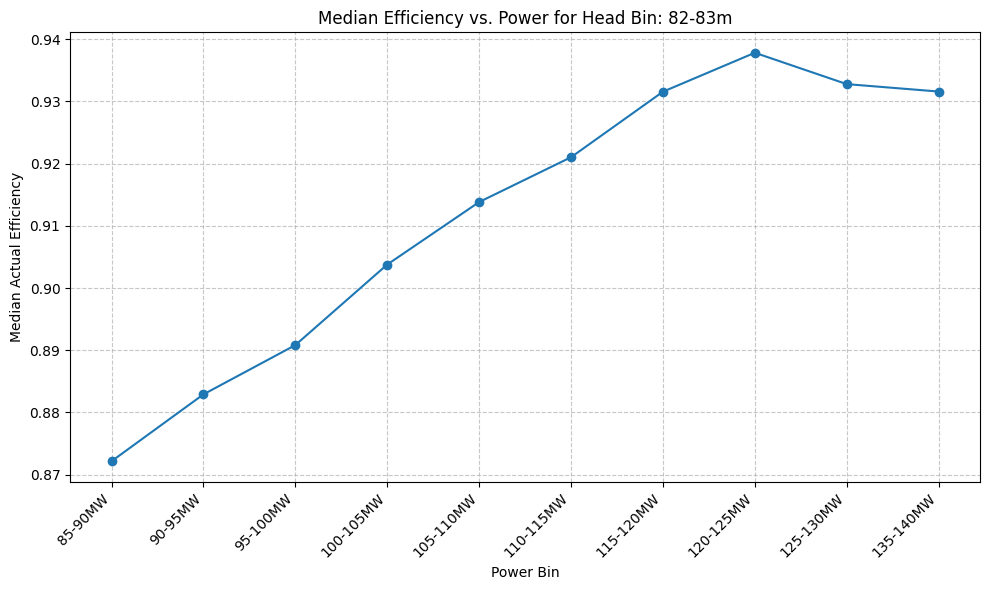

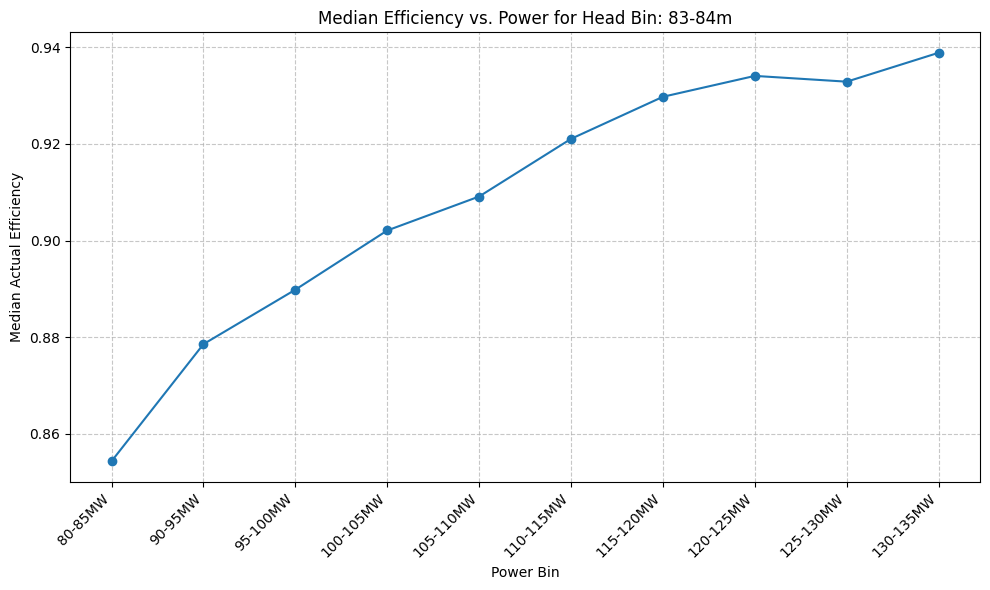

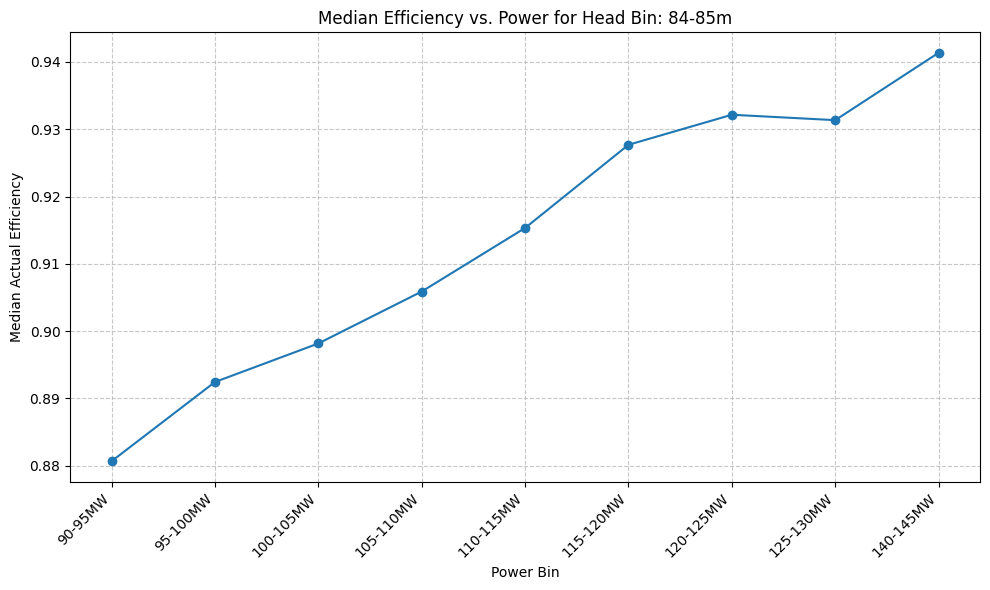

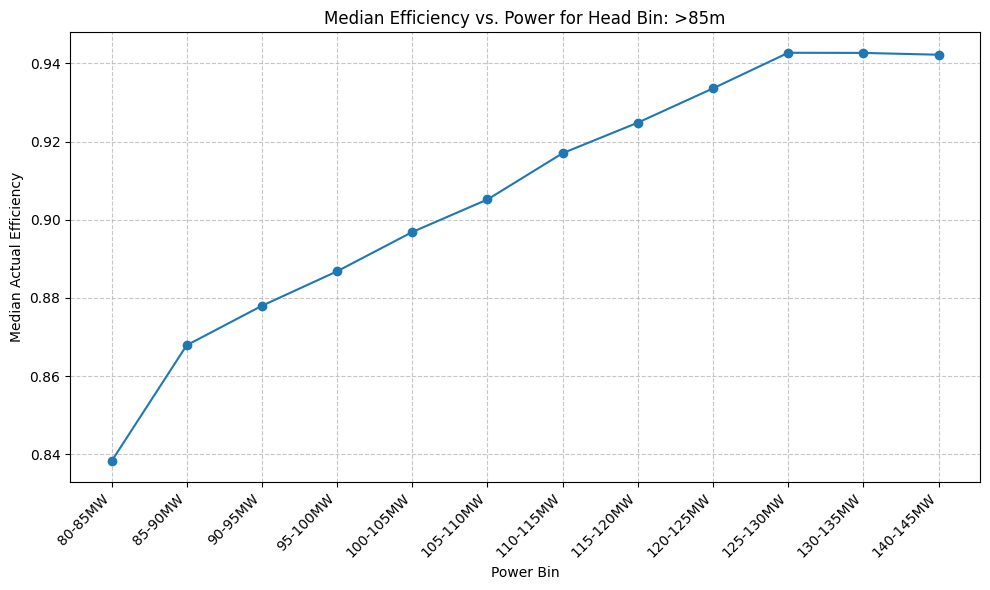

In [73]:
print("Visualizing Median Efficiency per Head Bin:")

# Iterate through each unique 'Head_bin' and create a plot
for head_bin_val in median_eta_per_bin['Head_bin'].unique():
    plt.figure(figsize=(10, 6))
    filtered_data = median_eta_per_bin[median_eta_per_bin['Head_bin'] == head_bin_val].dropna(subset=['Eta_actual'])

    if not filtered_data.empty:
        # Ensure 'Power_bin' is ordered correctly for plotting
        filtered_data['Power_bin_order'] = filtered_data['Power_bin'].apply(lambda x: int(x.split('-')[0]))
        filtered_data = filtered_data.sort_values(by='Power_bin_order')

        plt.plot(filtered_data['Power_bin'], filtered_data['Eta_actual'], marker='o')
        plt.xlabel("Power Bin")
        plt.ylabel("Median Actual Efficiency")
        plt.title(f"Median Efficiency vs. Power for Head Bin: {head_bin_val}")
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()

        # Sanitize head_bin_val for filename
        filename_head_bin = head_bin_val.replace(' ', '_').replace('>', 'gt').replace('-', '_')
        plt.savefig(os.path.join(out_dir, f"median_eta_head_{filename_head_bin}.png"), dpi=200)
        plt.show()
    else:
        print(f"No valid efficiency data for Head Bin: {head_bin_val}")

## Final Task: Summarize Findings

Based on the matched-point efficiency analysis for 2026, the following key findings can be observed from the calculated median efficiencies and the generated plots:

*   **Head Bin `82-83m`**: The median actual efficiency generally shows an increasing trend with power, peaking around the 120-125MW range and then slightly decreasing or stabilizing. This suggests an optimal operating point within this head range.

*   **Head Bin `83-84m`**: Similar to the previous bin, efficiency tends to rise with increasing power, reaching its highest values at higher power outputs. The efficiency curves indicate good performance across most of the operating range within this head.

*   **Head Bin `84-85m`**: This head bin also exhibits a positive correlation between power and efficiency. The median efficiencies appear to be consistently high within the observed power ranges.

*   **Head Bin `>85m`**: For head values above 85m, the median efficiencies also show an upward trend with power, indicating that the unit maintains good efficiency even at higher heads and power outputs. However, the data points in this bin might be fewer, as suggested by the plot.

Overall, the analysis reveals that the unit generally operates with higher efficiency at higher power outputs across all observed head ranges. The plots clearly visualize these trends, showing how median efficiency varies as the power demand increases within specific head operating conditions. This matched-point analysis provides valuable insights into the unit's performance characteristics in 2026, identifying potential optimal operating zones and efficiency behaviors under different conditions.

## Final Task

### Subtask:
Summarize the findings of the matched-point efficiency analysis, highlighting the efficiency performance across the different operating ranges in 2026.


## Summary:

### Q&A
The matched-point efficiency analysis for 2026 reveals that efficiency generally increases with power output across all observed head ranges. Specific trends are:
*   For the **82-83m head bin**, median actual efficiency typically increases with power, reaching a peak around the 120-125MW range before slightly declining or stabilizing.
*   For the **83-84m head bin**, efficiency also tends to rise with increasing power, achieving its highest values at higher power outputs.
*   The **84-85m head bin** consistently shows a positive correlation between power and efficiency, maintaining high median efficiencies within the observed power ranges.
*   For head values **above 85m ( >85m )**, median efficiencies exhibit an upward trend with power, suggesting good performance at higher heads and power outputs.

### Data Analysis Key Findings
*   The `op_cmp` DataFrame was successfully augmented with `Year`, `Head_bin`, and `Power_bin` columns, categorizing head into ranges like `82-83m` and power into 5 MW intervals (e.g., `115-120MW`).
*   Median `Eta_actual` (efficiency) was calculated for each unique combination of `Year`, `Head_bin`, and `Power_bin` for the year 2026.
*   Across all analyzed head ranges (82-83m, 83-84m, 84-85m, and >85m), the median actual efficiency consistently shows an increasing trend as power output increases.
*   Optimal efficiency appears to be achieved at higher power outputs within each head range. For instance, in the 82-83m head bin, efficiency peaks around the 120-125MW range.

### Insights or Next Steps
*   The analysis identifies potential optimal operating zones where the unit achieves higher efficiency, generally correlating with higher power outputs across various head conditions in 2026.
*   Further investigation into the slight decrease or stabilization of efficiency at very high power outputs (e.g., beyond 120-125MW for the 82-83m head bin) could reveal mechanical limitations or specific operational envelopes.
